In [61]:
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

#####################################3

from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# !rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dolfin version: 2019.1.0


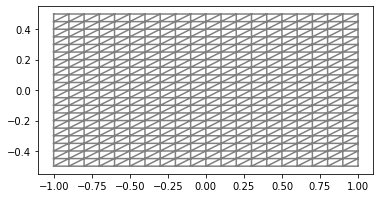

                            Calling FFC just-in-time (JIT) compiler, this may take some time.


ArityMismatch: ignored

In [84]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan 19 10:45:19 2020

@author: ehsan
"""
from __future__ import print_function
from fenics import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.tri as tri
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 13 17:44:01 2019
@author: ehsan
"""
L = 2
H = 1
nx = 20
ny = 20
mesh = RectangleMesh(Point(-L/2, -H/2), Point(L/2, H/2), nx, ny)
initial_mesh_coordinate = mesh.coordinates()
# Initializing material parameters
mu = Constant(1)
E1 = Constant(200/mu)#not correct
E2 = Constant(200/mu)#correct
c1 = Constant(80/mu)#correct
c2 = Constant(20/mu)#not correc1
p11 = Constant(100)


# Defining test and trial functions in splitted form
element = VectorElement('P', triangle, 1, dim=12)
V = FunctionSpace(mesh, element)
Q = FunctionSpace(mesh, "CG", 2)

plot(mesh)
plt.show()

v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9, v_10, v_11, v_12 = TestFunctions(V)
u = Function(V)
x1, x2, q, r, h, t, A, B, C, S, G, D = split(u)
#0, 1 , 2, 3, 4, 5, 6 ,7, 8, 9,10,11 
x, y = SpatialCoordinate(mesh)

# Defining Derivatives
#x1dx = project(x1.dx(0), Q)
#x1dy = project(x1.dx(1), Q)
#qdx = project(q.dx(0), Q)
#v_1dx = project(v_1.dx(0), Q)
#x2dx = project(x2.dx(0), Q)
#x2dy = project(x2.dx(1), Q)

# Defining non-linear terms...

# Defining boundary conditions
class left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0],-L/2)

#def left(x, on_boundary):
#    return near(x[0],0.)    

class right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0],L/2)
class top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1],H/2)
class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1],-H/2)
class middle(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0],0)
class sag(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1],0)
    
facets = MeshFunction("size_t", mesh, 1)
facets.set_all(0)
left().mark(facets, 1)
right().mark(facets, 2)
top().mark(facets, 3)
bottom().mark(facets, 4)
middle().mark(facets, 5)
sag().mark(facets, 6)
ds = Measure("ds", subdomain_data=facets)

##modification added for left and right edge 
u_R = Expression('x[1]', degree=1)
u_R1 = Expression('x[0]', degree=1)
bc = [DirichletBC(V.sub(0),Constant(0), facets, 5),#(x1 is 0 in the middle of fiber(symmetric))
      DirichletBC(V.sub(1),u_R , facets, 1),#(x2 remains the same on the left edge)
      DirichletBC(V.sub(1), u_R , facets, 2),#(x2 remains the same on the right edge)
      DirichletBC(V.sub(3), Constant(0) , facets, 1),#(r remains 0 the same on left right edge)
      DirichletBC(V.sub(3), Constant(0) , facets, 2),#(r remains 0 the same on the right edge)
# =============================================================================
#       DirichletBC(V.sub(3), Constant(2) , facets, 5),#(r remains 0 the same on left right edge)
# =============================================================================
      DirichletBC(V.sub(4), Constant(0) , facets, 5),#(r remains 0 the same on left right edge)
      ]##completely fixed edge (x2 remains the same on the right edge)


# =============================================================================
f_1 = project(c1*q.dx(0),Q)
f_2 = project(c1*r.dx(0),Q)
f_3 = project(c1*q.dx(0),Q)
f_4 = project(c1*r.dx(0),Q)
f_5 = project(x1.dx(0),Q)
f_6 = project(x2.dx(0),Q)
f_7 = project(x1.dx(1),Q)
f_8 = project(x2.dx(1),Q)
# =============================================================================
#+ ( -A * S  * v_1 + B * D  * v_1 + c1 * q.dx(0) * v_1 ) ) * dx 
f_9 = project(sqrt( ( (  -(2*mu )*q+p11   )/(E1/2) )+1-(q**2) ),Q)
#math.exp( (B/2)*( (C**2)+(D**2)-1) )
# =============================================================================
# EHSAN = (B/2)*( (C**2)+(D**2)-1) 
# PARIA = ( 1 + ( (B/2)*( (C**2)+(D**2)-1) ) + ((( (B/2)*( (C**2)+(D**2)-1) )*( (B/2)*( (C**2)+(D**2)-1) ))/2) )  # + ((EHSAN**3)/6) + ((EHSAN**4)/24) ##taylor expansion of exp function
# Define variational problem
F = ( mu * ( q + h ) * v_1 + ( A * B * ( 1 + ( (B/2)*( (C*C)+(D*D)-1) ) + ((( (B/2)*( (C*C)+(D*D)-1) )*( (B/2)*( (C*C)+(D*D)-1) ))/2) )  ) 
* ( ( B * ( ( q * ( C * C ) ) +  ( q * ( D * D ) ) + ( h * ( C * C) ) + ( h * ( D * D ) ) ) ) + q ) * v_1 
+ (  -A * S  * v_1 + B * D  * v_1 + c1 * q.dx(0)  ) * v_1 ) * dx 
+ ( mu * ( r + t ) * v_2 + ( A * B * ( 1 + ( (B/2)*( (C*C)+(D*D)-1) ) + ((( (B/2)*( (C*C)+(D*D)-1) )*( (B/2)*( (C*C)+(D*D)-1) ))/2) )  ) 
* ( ( B * ( ( r * ( C * C ) ) +  ( r * ( C * C ) ) + ( t * ( D * D ) ) + ( t * ( C * C ) ) ) ) + q ) * v_2  
+ ( -B * C  * v_2 + A * G  * v_2 + c1 * r.dx(0) * v_2 ) ) * dx  
+ ( A - mu * ( q + h ) + c1 * q.dx(0) )* v_3 * dx 
+ ( B - mu * ( r + t ) + c1 * r.dx(0) )* v_4 * dx 
+ (q*v_5+x1.dx(0)*v_5.dx(0))*dx+(r*v_6 +x2.dx(0)*v_6.dx(0))*dx +(h*v_7+x1.dx(1)*v_7.dx(1))*dx+(t*v_8+x2.dx(1)*v_8.dx(1))*dx  \
+ ( (C-x1.dx(0))*v_9*dx )+ ( (S-x2.dx(1))*v_10*dx )+ ( (G-x1.dx(1))*v_11*dx )+ ( (D-x2.dx(0))*v_12*dx )
- f_1*v_1*ds - f_2*v_2*ds - f_3*v_3*ds - f_4*v_4*ds - f_5*v_5*ds - f_6*v_6*ds-f_7*v_7*ds -f_8*v_8*ds 


###############3
##PICARD Iteration
u_ = Expression(('0','0','0','0','0','0','0','0','0','0','0','0'), degree =2)
u_k= interpolate(u_,V)
eps = 1.0
tol = 1.0E-2
iter = 0
maxiter = 25
solve(F == 0, u, bc)

# while eps > tol and iter < maxiter:
#     iter +=1
#     solve(F == 0, u, bc)
#     diff = u.vector().get_local() - u_k.vector().get_local()
#     eps = np.linalg.norm(diff, ord=np.Inf)
#     print ('iter= ', iter )
#     print ('eps= ', eps)
#     u_k.assign(u)

##to find the nodal values for each characteristic like x1,x2,...
u_nodal_values = np.zeros(((nx+1)*(ny+1),2))
j=-1
for i in range (0,12*(nx+1)*(ny+1),12):
    j=j+1
    u_nodal_values[j][0] = u.vector().get_local()[i]
    u_nodal_values[j][1] = u.vector().get_local()[i+1]
# =============================================================================
# def_x1= u_nodal_values[:,0] - initial_mesh_coordinate[:,0]
# def_x2= u_nodal_values[:,1] - initial_mesh_coordinate[:,1]
# =============================================================================
for i in range(0,(nx+1)*(ny+1),1):
    plt.plot(u_nodal_values[i][0],u_nodal_values[i][1],"o", color='green')
# =============================================================================
# plt.axis("equal")
# =============================================================================
plt.show() 
  
# Showing Results
x1, x2, q, r, h, t, A, B, C, S, G, D = u.split()

# =============================================================================
# =============================================================================
# =============================================================================
phi1 = project( - (abs(   C-( (C**3)/3 )+ ( (C**5)/5 ) )+ abs(   S-( (S**3)/3 )+ ( (S**5)/5 ) ) ) , Q )
# # =============================================================================
# =============================================================================
# =============================================================================
# =============================================================================
# =============================================================================
# phi2 = project(  (r*(1+G)-(D*H) )/((D**2)+(1+G)**2) , Q )
# =============================================================================
# =============================================================================
# plt.triplot(u_nodal_values[:,0], u_nodal_values[:,1],mesh.cells())    
# plt.show()
# =============================================================================
phi2 = project( -abs(   G-( (G**3)/3 )+ ( (G**5)/5 ) )+ abs(   D-( (D**3)/3 )+ ( (D**5)/5 ) ) , Q )
phi3 = project( abs( ( (t*S)-(C*h) )/(   (C**2)+(G**2) ) ) , Q )





plot(phi1, title="x1 plot" , mode= "color")


plot(x1, title="x1 plot" , mode= "color")
plt.show()
plot(x2, title="x2 plot", mode='color')
plt.show()


vtkfile_x1 = File('/content/drive/My Drive/fiber_project/x1.pvd')
vtkfile_x2 = File('/content/drive/My Drive/fiber_project/x2.pvd')
vtkfile_phi = File('/content/drive/My Drive/fiber_project/phi.pvd')

vtkfile_x1 << (x1)
vtkfile_x2 << (x2) 
vtkfile_phi << (phi1) 



In [0]:
!pwd 


/content
